In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import numpy as np
from natsort import natsorted
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [118]:
import sys
original_path = os.getcwd()  
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)
from smoothing_function import *
from model_analysis_function import *
from analysis_function import *
from Plot_function import *
from ar6_area_weighted_cont_global import *
# from obs_function import *

## Constrain global temperature
### Load global data

In [4]:
path = '/Users/tongli1997/Library/CloudStorage/OneDrive-UniversityofVictoria/Codes_run_on_local/Global_regional_attribution/Augest_Sep_2025/saved_data/'

file_name = '0.CRUT5&HadCRUT5.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2024.nc'
obs_all= xr.open_dataarray(path + file_name) 

file_name = '0.HadCRUT5.200runs.nan-masked.to.CRUT5.Tas.anomalies.AR6.continental.LSAT.GSAT.46regions_175years.nc'
obs_200runs_all = xr.open_dataarray(path + file_name) 

file_name = '0.Smoothed.His-ALL-nat-ant-ghg-oa.nan-masked.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2025.nc'
mod_all = xr.open_dataarray(path + file_name) 

file_name = '0.Large_ensembles.320runs.nan-masked.full.time.series.Tas.anomalies.AR6.continental.LSAT.GSAT.1850-2025.nc'
ln_mod_all = xr.open_dataarray(path + file_name) 

file_name = '0.pseudo-model_45.run1-3.Tas.anomalies.AR6.continental.LSAT.GSAT.46regions_176years.1850-2025.nc'
mod_45_pseudo = xr.open_dataarray(path + file_name) 

file_name = '0.Smoothed.His-Fu.24mod.1850-2100.non.masked.Tas.anomalies.AR6.continental.global.nc'
mod_all_his_fu= xr.open_dataarray(path + file_name).expand_dims(forcing = ['ALL'])

In [5]:
ref_period = (1850, 1900)
current_year = 2025
target_reg = ['GSAT']
constrain_used_reg = ['GSAT']


from f1_0_H_sum_multi_region_constrain import *

constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_his_fu
mod_da = mod_all_his_fu
region_names = list(mod_da.names.values)
his_forcing = ['ALL']
sel_forcing=['ALL']

prior_mean, prior_cov, post_mean, post_cov = process_sum_multiple_region_mean_cov_constrain(constrain_func, constrain_used_reg, target_reg, his_forcing, sel_forcing, obs, obs_200runs, ln_mod, mod_his, mod_da)


prior_gsat_ref18 = change_ref(prior_mean.sel(forcing = 'ALL'), ref_period[0], ref_period[1])
post_gsat_ref18 = change_ref(post_mean.sel(forcing = 'ALL'), ref_period[0], ref_period[1])


def find_yr(data, threshold): 
    yr = int(data.where(data >= threshold, drop=True).year.values[0])
    print(yr)
    return (yr)

gsat_2_post = find_yr(post_gsat_ref18, threshold = 2)
gsat_15_post = find_yr(post_gsat_ref18, threshold = 1.5)

gsat_2_prior = find_yr(prior_gsat_ref18, threshold = 2)
gsat_15_prior = find_yr(prior_gsat_ref18, threshold = 1.5)


2042
2029
2041
2028


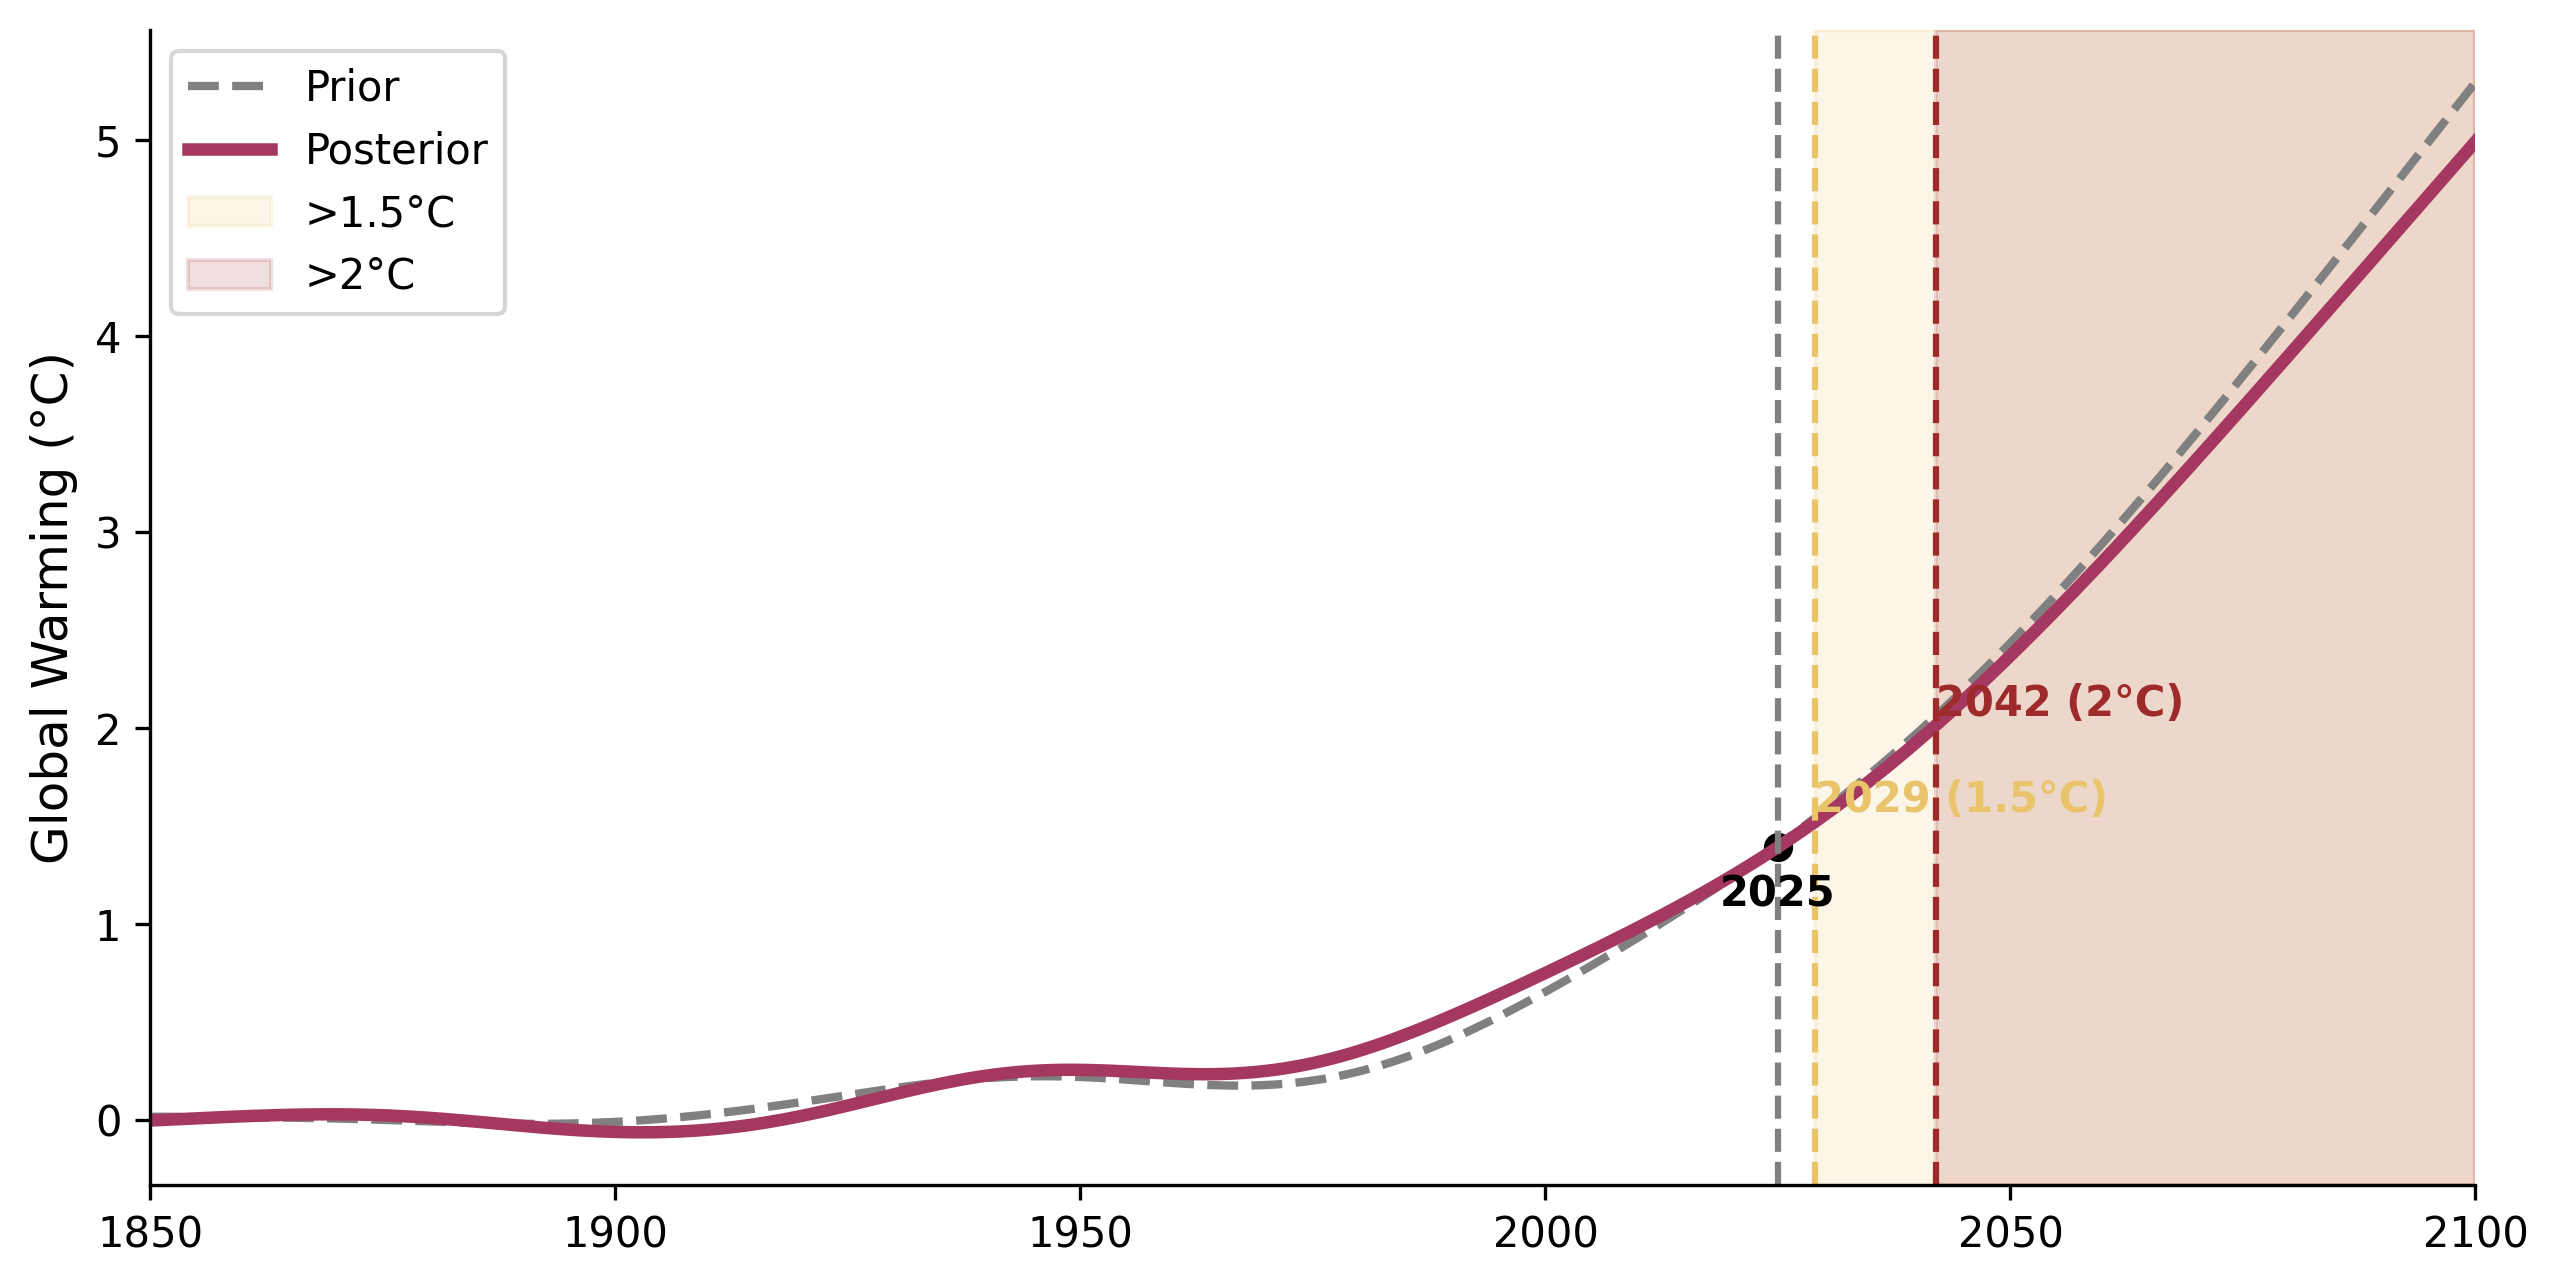

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5
), dpi=300, sharey=True)

plt.plot(prior_gsat_ref18['year'], prior_gsat_ref18, label = 'Prior', color = 'gray', ls = '--', lw = 2)
plt.plot(post_gsat_ref18['year'], post_gsat_ref18, label = 'Posterior', color = '#a53860', ls = '-', lw = 3)


color_15 = '#e9c46a'
color_2 = '#9e2a2b'
# Shade time period after 1.5°C
ax.axvspan(gsat_15_post, 2100, color= color_15, alpha=0.15, label='>1.5°C')

# Shade time period after 2°C
ax.axvspan(gsat_2_post, 2100, color= color_2, alpha=0.15, label='>2°C')


ax.axvline(gsat_15_post, color= color_15, ls='--', lw=1.5)
ax.axvline(gsat_2_post, color= color_2, ls='--', lw=1.5)

ax.axvline(current_year, color='gray', ls='--', lw=1.5)

# ---- Label 1.5°C ----
y15 = post_gsat_ref18.sel(year=gsat_15_post)
ax.text(gsat_15_post, y15 + 0.05,
        f"{gsat_15_post} (1.5°C)",
        color= color_15, ha='left', weight = 'bold', fontsize=10)

# ---- Label 2°C ----
y2 = post_gsat_ref18.sel(year=gsat_2_post)
ax.text(gsat_2_post, y2 + 0.05,
        f"{gsat_2_post} (2°C)",
        color= color_2, ha='left', weight = 'bold', fontsize=10)

# ---- Label current year ----
y_curr = post_gsat_ref18.sel(year=current_year)
ax.scatter(current_year, y_curr, color='black')
ax.text(current_year, y_curr - 0.3,
        f"{current_year}",
        color='black', ha='center', weight = 'bold', fontsize=10)

ax.set_ylabel("Global Warming (°C)", fontsize=12)

plt.xlim(1850, 2100)
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Constrain the regional, continent and global land warming

### Load the regional, continent and global land data

In [152]:
path = './saved_data/'

def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

obs_all = load_xr_pickle(path + '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

obs_200runs_all = load_xr_pickle(path + '0.2.HadCRUT5.200runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl')

mod_all_his_fu = load_xr_pickle(path + '0.4.Smoothed_His-Fu-ALL.25mods.mean.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

ln_mod_all = load_xr_pickle(path + '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

mod_45_pseudo = load_xr_pickle(path + '0.5.pseudo-model.15mod.run1-3.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_176years_1850-2025.pkl')

print_xarray_info(obs_all, obs_200runs_all, mod_all_his_fu, ln_mod_all, mod_45_pseudo)


Array 1:
  Sizes: Frozen({'year': 175, 'region': 54})
  Coords: ['realization', 'year', 'region', 'abbrevs', 'names']

Array 2:
  Sizes: Frozen({'runs': 200, 'year': 175, 'region': 54})
  Coords: ['runs', 'year', 'region', 'abbrevs', 'names']

Array 3:
  Sizes: Frozen({'forcing': 1, 'model_name': 25, 'year': 251, 'region': 54})
  Coords: ['model_name', 'region', 'year', 'abbrevs', 'names', 'forcing']

Array 4:
  Sizes: Frozen({'model_run': 320, 'year': 251, 'region': 54})
  Coords: ['year', 'model_run', 'model_name', 'region', 'abbrevs', 'names']

Array 5:
  Sizes: Frozen({'model_run': 45, 'year': 176, 'region': 54})
  Coords: ['model_run', 'year', 'model_name', 'region', 'abbrevs', 'names']


[{'target_reg': 'GIC', 'constrain_used_reg': ['GIC', 'LSAT']},
 {'target_reg': 'NWN', 'constrain_used_reg': ['NWN', 'LSAT']},
 {'target_reg': 'NEN', 'constrain_used_reg': ['NEN', 'LSAT']},
 {'target_reg': 'WNA', 'constrain_used_reg': ['WNA', 'LSAT']},
 {'target_reg': 'CNA', 'constrain_used_reg': ['CNA', 'LSAT']},
 {'target_reg': 'ENA', 'constrain_used_reg': ['ENA', 'LSAT']},
 {'target_reg': 'NCA', 'constrain_used_reg': ['NCA', 'LSAT']},
 {'target_reg': 'SCA', 'constrain_used_reg': ['SCA', 'LSAT']},
 {'target_reg': 'CAR', 'constrain_used_reg': ['CAR', 'LSAT']},
 {'target_reg': 'NWS', 'constrain_used_reg': ['NWS', 'LSAT']},
 {'target_reg': 'NSA', 'constrain_used_reg': ['NSA', 'LSAT']},
 {'target_reg': 'NES', 'constrain_used_reg': ['NES', 'LSAT']},
 {'target_reg': 'SAM', 'constrain_used_reg': ['SAM', 'LSAT']},
 {'target_reg': 'SWS', 'constrain_used_reg': ['SWS', 'LSAT']},
 {'target_reg': 'SES', 'constrain_used_reg': ['SES', 'LSAT']},
 {'target_reg': 'SSA', 'constrain_used_reg': ['SSA', 'L

### Constrained warming relative to current year 2025

In [68]:
#### global_region constraint
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_his_fu
mod_da = mod_all_his_fu
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ALL']
constrain_forcing_names=['ALL']

scheme_pairs =  pair_all

_, _, prior_smooth_ALL_ref2025, post_smooth_ALL_ref2025, obs_adj_ALL_ref2025 = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, 
    reg_id = slice(0, len(region_names)),
    uncertainty_ref_period=(1850, 2025),
    ref_period=(2025, 2026),
    obs_adjust_ref_period=(1961, 2025),
    warming_target_period=(2016, 2025),
    calc_smoothed = True, 
    print_constraint_regions = True)




Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

In [69]:
#### Difference of 1.5, 2 world relative to current warming
# prior_warming_15_ref2025 = prior_smooth_ALL_ref2025.sel(year = slice(gsat_15_post-5, gsat_15_post+5)).mean('year').squeeze()
# prior_warming_2_ref2025 = prior_smooth_ALL_ref2025.sel(year = slice(gsat_2_post-5, gsat_2_post+5)).mean('year').squeeze()

post_warming_15_ref2025 = post_smooth_ALL_ref2025.sel(year = slice(gsat_15_post-5, gsat_15_post+5)).mean('year').squeeze()
post_warming_2_ref2025 = post_smooth_ALL_ref2025.sel(year = slice(gsat_2_post-5, gsat_2_post+5)).mean('year').squeeze()

### Constrained warming relative to pre-industrial 1850-1900 year

In [70]:
#### global_region constraint
constrain_func = constrain_sum_reg
obs = obs_all
obs_200runs = obs_200runs_all
ln_mod = ln_mod_all
mod_his = mod_all_his_fu
mod_da = mod_all_his_fu
obs_ar6 = obs_all
region_names = list(mod_da.names.values)
forcing_list = mod_da.forcing  # xarray.DataArray
his_forcing = ['ALL']
constrain_forcing_names=['ALL']

scheme_pairs =  pair_all

_, _, prior_smooth_ALL_ref1850, post_smooth_ALL_ref1850, obs_adj_ALL_ref1850 = \
    process_all_regions(scheme_pairs, constrain_func, obs, obs_200runs, ln_mod, mod_his, mod_da, obs_ar6, region_names, forcing_list, his_forcing, constrain_forcing_names, 
    reg_id = slice(0, len(region_names)),
    uncertainty_ref_period=(1850, 2025),
    ref_period=(1850, 1900),
    obs_adjust_ref_period=(1961, 2025),
    warming_target_period=(2016, 2025),
    calc_smoothed = True, 
    print_constraint_regions = True)




Processing region 0: Greenland/Iceland
 Constraining used region 0: ['GIC', 'LSAT']
Processing region 1: N.W.North-America
 Constraining used region 1: ['NWN', 'LSAT']
Processing region 2: N.E.North-America
 Constraining used region 2: ['NEN', 'LSAT']
Processing region 3: W.North-America
 Constraining used region 3: ['WNA', 'LSAT']
Processing region 4: C.North-America
 Constraining used region 4: ['CNA', 'LSAT']
Processing region 5: E.North-America
 Constraining used region 5: ['ENA', 'LSAT']
Processing region 6: N.Central-America
 Constraining used region 6: ['NCA', 'LSAT']
Processing region 7: S.Central-America
 Constraining used region 7: ['SCA', 'LSAT']
Processing region 8: Caribbean
 Constraining used region 8: ['CAR', 'LSAT']
Processing region 9: N.W.South-America
 Constraining used region 9: ['NWS', 'LSAT']
Processing region 10: N.South-America
 Constraining used region 10: ['NSA', 'LSAT']
Processing region 11: N.E.South-America
 Constraining used region 11: ['NES', 'LSAT']
Proc

In [ ]:
current_yr = 2025
post_warming_current_year = post_smooth_ALL_ref1850.sel(year = current_yr, quantile = 'mean').squeeze()

percent_nowaday_15 = (post_warming_current_year / (post_warming_current_year + post_warming_15_ref2025)) * 100
percent_nowaday_2 = (post_warming_current_year / (post_warming_current_year + post_warming_2_ref2025)) * 100


## switch 5, 95th, cause it is on denorminator
percent_nowaday_15 = percent_nowaday_15.rename({'quantile': 'quantile'})
percent_nowaday_15 = percent_nowaday_15.assign_coords(
    quantile=['95th' if q == '5th' else '5th' if q == '95th' else q for q in percent_nowaday_15['quantile'].values]
)

percent_nowaday_2 = percent_nowaday_2.rename({'quantile': 'quantile'})
percent_nowaday_2 = percent_nowaday_2.assign_coords(
    quantile=['95th' if q == '5th' else '5th' if q == '95th' else q for q in percent_nowaday_2['quantile'].values]
)
percent_nowaday_15

<xarray.DataArray 'post_mean_5_95_smooth' (region: 54, quantile: 3)> Size: 1kB
array([[ 92.32282959, 134.07470021,  70.28950277],
       [ 91.73769076, 117.23608902,  76.86204747],
       [ 91.83305613, 112.80764791,  74.37614858],
       [ 91.61133513, 111.53686485,  78.70873708],
       [ 91.77152496, 109.23061798,  80.10860199],
       [ 91.16297825, 105.36248672,  78.30598575],
       [ 91.42855641, 105.35426665,  80.63205882],
       [ 91.06005836, 102.7355395 ,  78.78143387],
       [ 91.32560942, 104.67004634,  80.35143164],
       [ 91.64606468, 115.61789865,  78.26212609],
       [ 90.75964787, 123.14073457,  74.45969034],
       [ 92.68975868, 110.38847053,  80.73417218],
       [ 90.32333938, 111.67827937,  76.17151751],
       [ 89.75508806, 112.17762277,  75.4781786 ],
       [ 92.23140145, 111.24462441,  79.50406337],
       [ 92.73569851, 114.4446661 ,  80.61941278],
       [ 92.61883826, 120.38054755,  74.61916729],
       [ 91.41117953, 108.25608563,  79.70048059],
       [ 91.56980304, 111.99680472,  77.96930114],
       [ 91.26376865, 105.07219054,  79.15204189],
...
       [ 91.84769476, 110.45975949,  78.39058582],
       [ 90.52817931, 101.55395043,  79.6502294 ],
       [ 91.45981726, 106.85251934,  79.55669846],
       [ 90.58931096, 106.37625775,  76.10707999],
       [ 91.45405958, 103.67065405,  76.95999204],
       [ 91.58970513, 105.50932688,  77.26752588],
       [ 91.23235019, 112.35955326,  77.41207244],
       [ 91.6162341 , 108.17619372,  82.086543  ],
       [ 93.87152901, 110.9050294 ,  78.58191732],
       [ 91.55354648, 110.20033793,  78.78215658],
       [ 91.77930391, 139.69209715,  68.3230465 ],
       [ 92.0218288 , 171.54673971,  62.51202403],
       [ 92.52901991, 107.41658195,  80.91049641],
       [ 91.33510667, 105.74079783,  79.55084454],
       [ 91.37888589, 104.6731912 ,  82.20717439],
       [ 92.21444153, 103.6050304 ,  84.28099209],
       [ 90.78625959, 103.16809495,  80.7860717 ],
       [ 91.51871468, 102.53480259,  83.1599218 ],
       [ 91.69226882, 142.49349698,  67.90026777],
       [ 91.59521463, 108.14725822,  81.60838187]])
Coordinates:
  * region       (region) int64 432B 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
    year         int64 8B 2025
    forcing      <U3 12B 'ALL'
    abbrevs      (region) <U4 864B 'GIC' 'NWN' 'NEN' 'WNA' ... 'AU' 'ANT' 'LSAT'
    names        (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'
    realization  int64 8B 100
  * quantile     (quantile) <U4 48B 'mean' '95th' '5th'

### Global land constrain


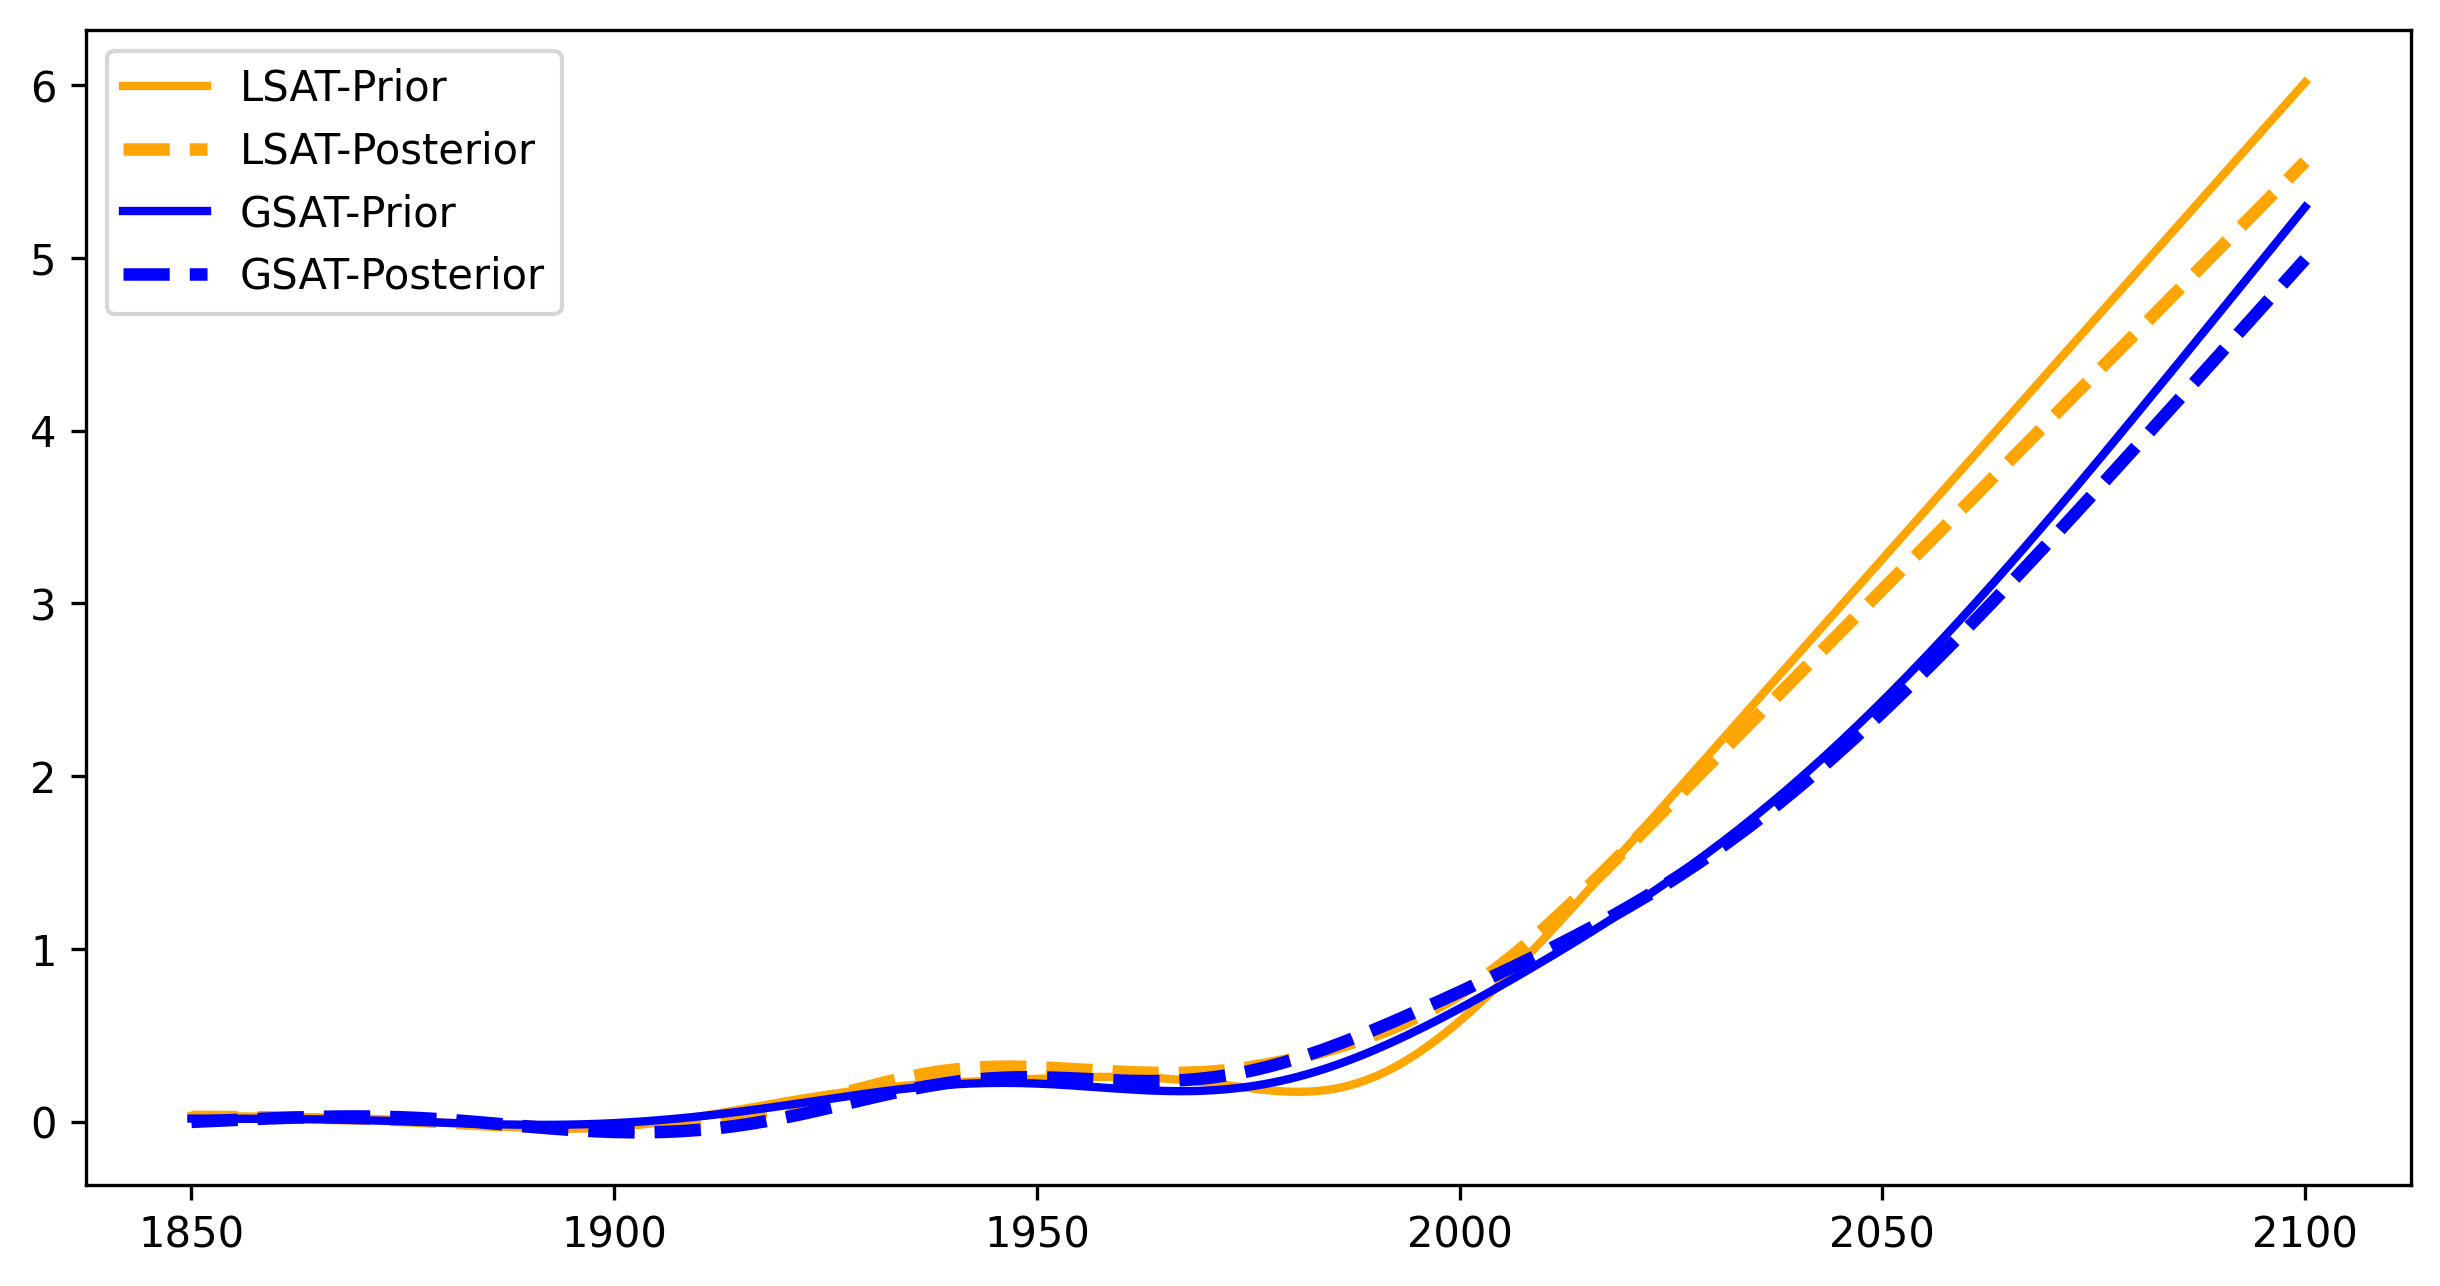

In [84]:
lsat_prior = prior_smooth_ALL_ref1850.sel(region = 53, quantile = 'mean').squeeze()
lsat_post = post_smooth_ALL_ref1850.sel(region = 53, quantile = 'mean').squeeze()


fig, ax = plt.subplots(1, 1, figsize=(10, 5
), dpi=300, sharey=True)

plt.plot(lsat_prior['year'], lsat_prior, label = 'LSAT-Prior', color = 'orange', ls = '-', lw = 2)
plt.plot(lsat_post['year'], lsat_post, label = 'LSAT-Posterior', color = 'orange', ls = '--', lw = 3)

plt.plot(prior_gsat_ref18['year'], prior_gsat_ref18, label = 'GSAT-Prior', color = 'blue', ls = '-', lw = 2)
plt.plot(post_gsat_ref18['year'], post_gsat_ref18, label = 'GSAT-Posterior', color = 'blue', ls = '--', lw = 3)

plt.legend()
plt.show()

### Map plotting

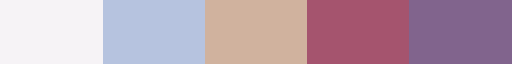

In [85]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


cmap_percent = modify_cmap('twilight', start=0.0, end=0.9, gamma=1.0, white_strength=0.7)   # example: different color map
bounds2 = np.arange(50, 110, 10)  # example levels
norm2 = mcolors.BoundaryNorm(boundaries=bounds2, ncolors=256, extend='neither')

n_colors = len(bounds2) - 1  # = 5

# Get discrete colors from the colormap
colors_n = [cmap_percent(i / (n_colors - 1)) for i in range(n_colors)]

# Swap the 5th color into 3rd position
# Note: Python is 0-based -> 5th = index 4, 3rd = index 2
colors_n[2], colors_n[4] = colors_n[4], colors_n[2]

# Create a new colormap with the modified order
cmap_percent = mcolors.ListedColormap(colors_n)

# Recreate the norm
norm2 = mcolors.BoundaryNorm(boundaries=bounds2, ncolors=cmap_percent.N, extend='neither')

cmap_percent

/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_57790/3531396450.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


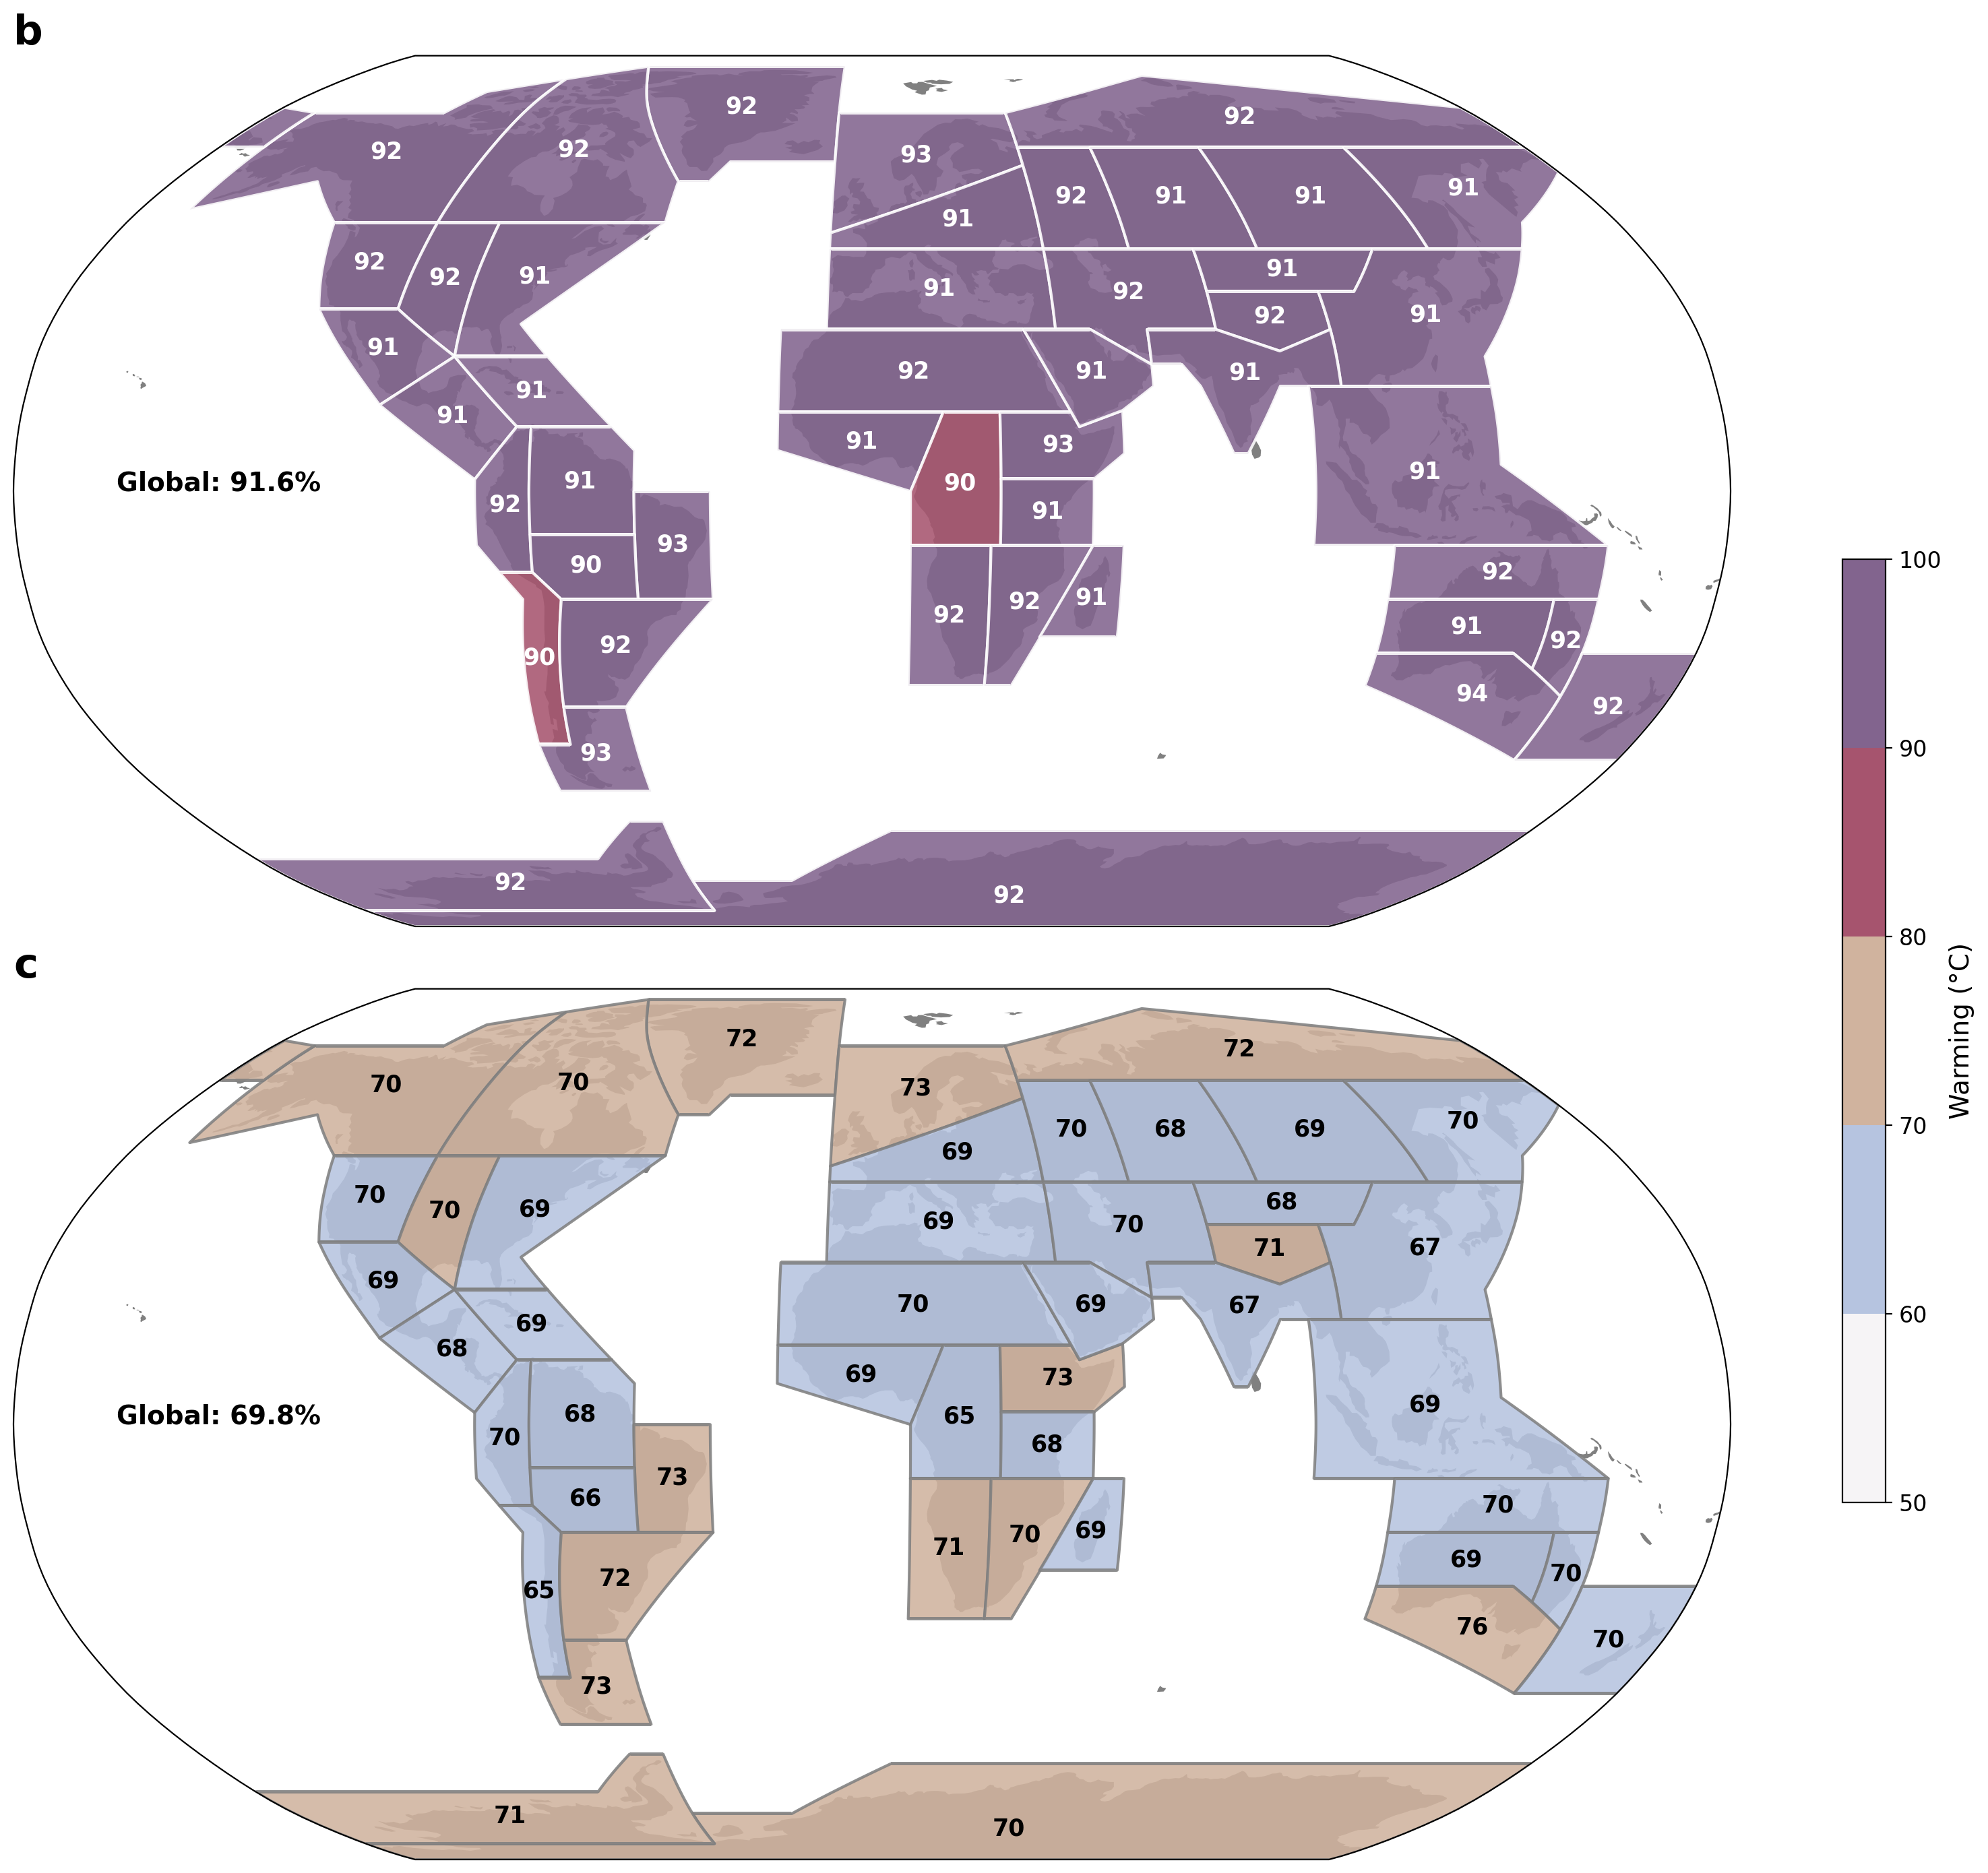

In [86]:
def plot_panel(ax, data, title, cmap, norm, decimals,
               global_value=None, unit="°C"):
    
    ax.set_global()
    norm0 = plot_ar6_region_data_on_ax_new(
        ax, data, cmap=cmap, norm=norm, decimals=decimals
    )

    # ---- Add title ----
    ax.set_title(title, fontsize=22, fontweight='bold', loc='left')

    # ---- Add the global value with a unit ----
    if global_value is not None:
        ax.text(
            0.06, 0.5,
            f"Global: {global_value:.1f}{unit}",   # unit inserted here
            transform=ax.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )

    return norm0

# ---- Data dictionary ----
# data_dict = {
#     "(b) Nowadays to 1.5°C": percent_nowaday_15.sel(quantile = 'mean'),     # existing data
#     "(c) Nowadays to 2°C": percent_nowaday_2.sel(quantile = 'mean')    # add your second data array here
# }

data_dict = {
    "b": percent_nowaday_15.isel(region = slice(0,46)).sel(quantile = 'mean'),     # existing data
    "c": percent_nowaday_2.isel(region = slice(0,46)).sel(quantile = 'mean')    # add your second data array here
}

global_15 = percent_nowaday_15.where(percent_nowaday_15.abbrevs == 'LSAT', drop=True).sel(quantile = 'mean').values.item()
global_2 = percent_nowaday_2.where(percent_nowaday_2.abbrevs == 'LSAT', drop=True).sel(quantile = 'mean').values.item()

global_values = {
    "b": global_15,
    "c": global_2
}

# ---- Plot 2 panels ----
fig, axes = plt.subplots(2, 1, figsize=(16, 14), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)

for ax, (label, data) in zip(axes, data_dict.items()):
    plot_panel(ax, data, f"{label}", cmap_percent, norm2, decimals = 0, global_value=global_values[label], unit = '%')

# ---- Shared colorbar ----
sm = mpl.cm.ScalarMappable(cmap=cmap_percent, norm=norm2)
sm.set_array([])

# [left, bottom, width, height] in figure coordinates (0–1)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.5])  
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=12)
cb.set_label("Warming (°C)", fontsize=14)

plt.tight_layout()
plt.show()


/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_57790/669259954.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


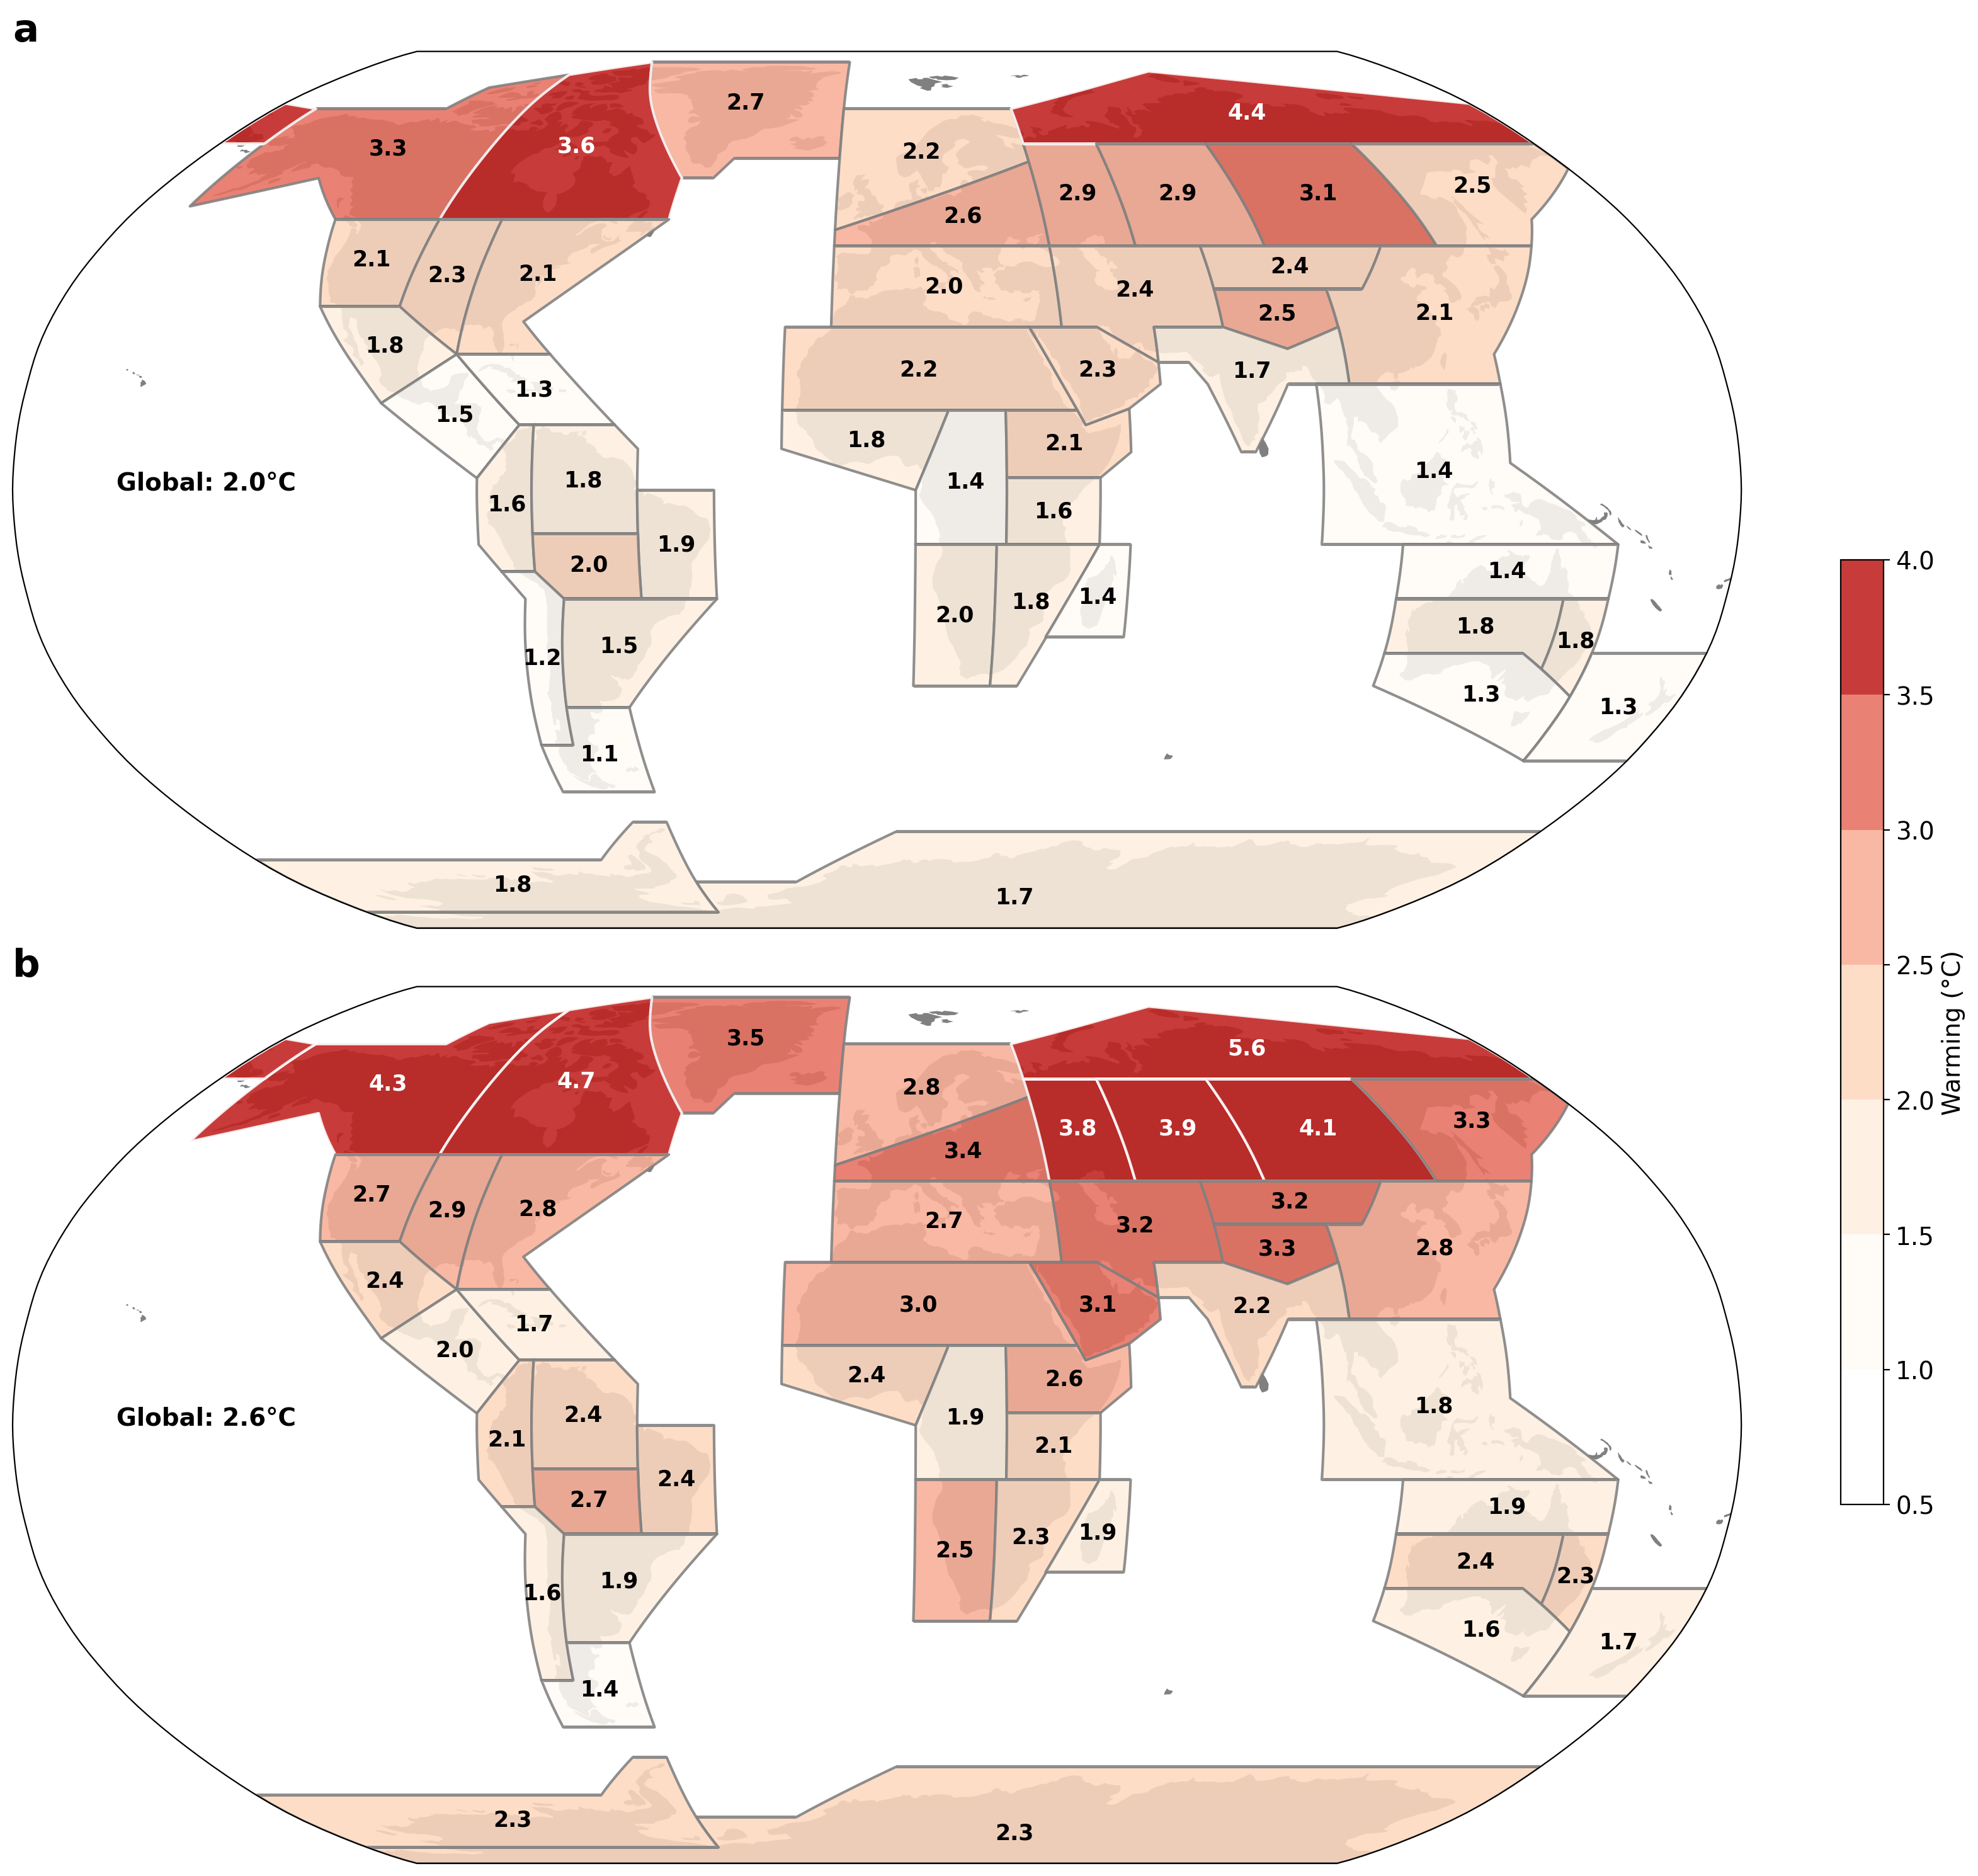

In [87]:
def set_cmap_alpha(cmap, alpha=1.0):
    colors = cmap(np.arange(cmap.N))
    colors[:, -1] = alpha
    return mpl.colors.ListedColormap(colors)

cmap = modify_cmap('OrRd', start=0.0, end=0.95, gamma=1.0, white_strength=1.0)
colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[:230]
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)
cmap_with_alpha = set_cmap_alpha(truncated_cmap, alpha=0.88)


# ---- Data dictionary ----
# data_dict = {
#     "1.5°C Warming world": post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year,
#     "2°C Warming world": post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year    # add your second data array here
# }

data_a = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(0, 46))
data_b = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(0, 46))

data_dict = {
    "a": data_a,
    "b": data_b    # add your second data array here
}

global_15 = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).where(post_warming_15_ref2025.abbrevs == 'LSAT', drop=True).values.item()

global_2 = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).where(post_warming_2_ref2025.abbrevs == 'LSAT', drop=True).values.item()

global_values = {
    "a": global_15,
    "b": global_2
}

bounds = np.arange(0.5, 4.5, 0.5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

# ---- Plot 2 panels ----
fig, axes = plt.subplots(2, 1, figsize=(17, 15), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)
for ax, (label, data) in zip(axes, data_dict.items()):
    plot_panel(ax, data, f"{label}", cmap_with_alpha, norm, decimals = 1, global_value=global_values[label], unit = '°C')

# ---- Shared colorbar ----
sm = mpl.cm.ScalarMappable(cmap=cmap_with_alpha, norm=norm)
sm.set_array([])


# [left, bottom, width, height] in figure coordinates (0–1)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.5])  
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=14)
cb.set_label("Warming (°C)", fontsize=14)

plt.tight_layout()
plt.show()

### AR6 region, area-mean-average

In [138]:
percent_reg_15 = percent_nowaday_15.sel(quantile = 'mean')
percent_reg_2 = percent_nowaday_2.sel(quantile = 'mean')
warming_reg_15 = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year)
warming_reg_2 = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year)


In [143]:
percent_reg_15_weighted_cont_glob = compute_continent_and_global_da(percent_reg_15)
percent_reg_2_weighted_cont_glob = compute_continent_and_global_da(percent_reg_2)

warming_reg_15_weighted_cont_glob = compute_continent_and_global_da(warming_reg_15)
warming_reg_2_weighted_cont_glob = compute_continent_and_global_da(warming_reg_2)

In [144]:
percent_15_constraint_cont_glob = percent_nowaday_15.isel(region = slice(46, 54)).sel(quantile = 'mean')
percent_2_constraint_cont_glob = percent_nowaday_2.isel(region = slice(46, 54)).sel(quantile = 'mean')

warming_15_constraint_cont_glob = (post_warming_15_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(46, 54))
warming_2_constraint_cont_glob = (post_warming_2_ref2025.sel(quantile = 'mean') + post_warming_current_year).isel(region = slice(46, 54))


In [151]:
print(warming_15_constraint_cont_glob)
print(warming_reg_15_weighted_cont_glob)

print(warming_2_constraint_cont_glob)
print(warming_reg_2_weighted_cont_glob)


<xarray.DataArray 'post_mean_5_95_smooth' (region: 8)> Size: 64B
array([2.57826046, 1.57687197, 2.48916558, 1.92683369, 2.76049617,
       1.41521201, 1.71324949, 2.01127173])
Coordinates:
  * region       (region) int64 64B 46 47 48 49 50 51 52 53
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    abbrevs      (region) <U4 128B 'NA' 'SA' 'EU' 'AF' 'Asia' 'AU' 'ANT' 'LSAT'
    names        (region) <U25 800B 'North and Central America' ... 'Global L...
    realization  int64 8B 100
    year         int64 8B 2025
<xarray.DataArray 'area_weighted_mean' (region: 8)> Size: 64B
array([2.5286823 , 1.60819634, 2.32126287, 1.86864912, 2.69471768,
       1.42097346, 1.75052647, 2.09645574])
Coordinates:
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    realization  int64 8B 100
    year         int64 8B 2025
    abbrevs      (region) <U4 128B 'NA' 'SA' 'EU' 'AF' 'Asia' 'AU' 'ANT' 'LSAT'
    names        (region) <U25 800B 'North and Central America' ... 'Global 

In [150]:
# print(percent_15_constraint_cont_glob)
# print(percent_reg_15_weighted_cont_glob)

# print(percent_2_constraint_cont_glob)
# print(percent_reg_2_weighted_cont_glob)


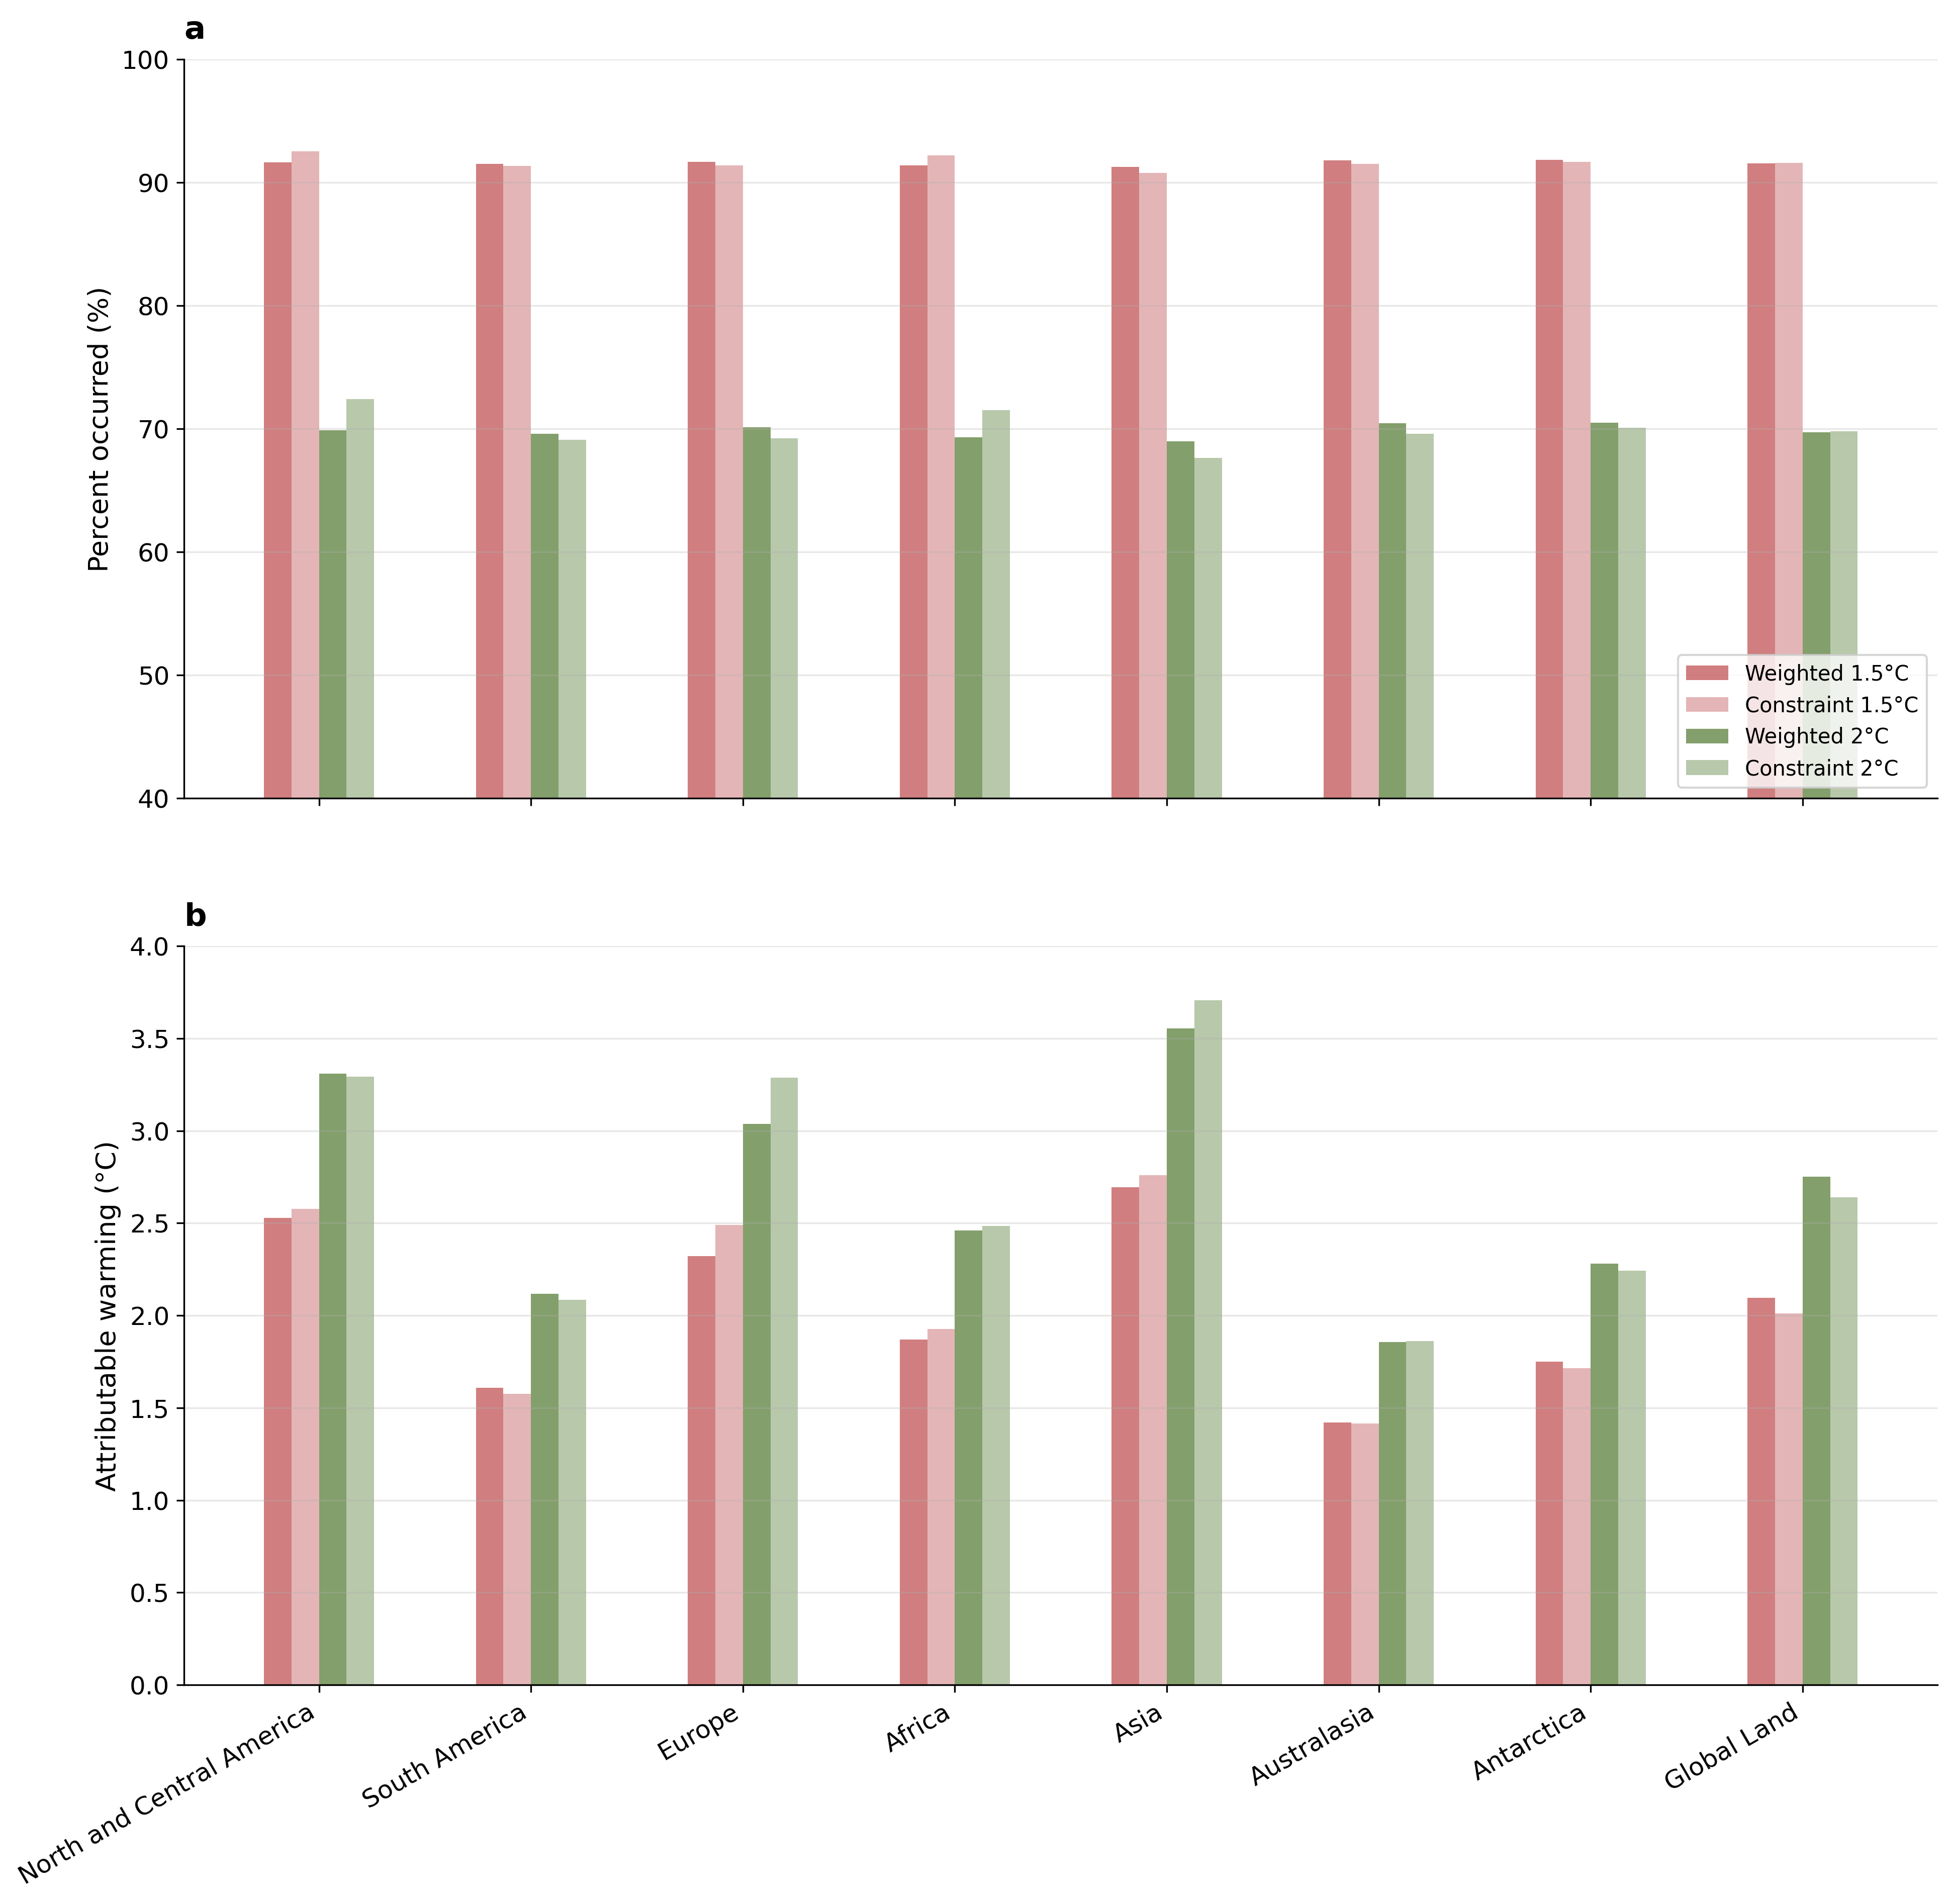

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_bars(ax, labels, data_dict, ylabel, ylim=None, legend_loc="lower right", title=None, legend = True):
    """
    ax: subplot axis
    labels: list of region names
    data_dict: dict of {label: array}
    """
    x = np.arange(len(labels))
    width = 0.13

    # Colors for 1.5C and 2C
    c15 = '#bc4749'
    c2  = '#4f772d'

    # Ordered plotting
    keys = list(data_dict.keys())
    offsets = [-1.5, -0.5, 0.5, 1.5]

    for k, off in zip(keys, offsets):
        color = c15 if "1.5" in k else c2
        alpha = 0.7 if "Weighted" in k else 0.4
        ax.bar(x + off * width, data_dict[k], width,
               label=k, color=color, alpha=alpha)

    # axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize = 12)
    ax.set_ylabel(ylabel, fontsize = 13)
    ax.tick_params(axis='y', labelsize=12)

    # limits
    if ylim:
        ax.set_ylim(ylim)

    # grid
    ax.grid(axis='y', alpha=0.3)

    # remove upper/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # legend
    if legend:
        ax.legend(loc=legend_loc)

    # panel title
    if title:
        ax.set_title(title, weight = 'bold', loc = 'left', fontsize=15, pad=10)


# ====== Prepare labels ======
labels = percent_reg_15_weighted_cont_glob['names'].values

# ====== Create figure with 2 rows ======
fig, axes = plt.subplots(2, 1, figsize=(15, 14), sharex=True, dpi = 300)

# ----- Row 1: Percent warming -----
percent_data = {
    "Weighted 1.5°C": percent_reg_15_weighted_cont_glob.values,
    "Constraint 1.5°C": percent_15_constraint_cont_glob.values,
    "Weighted 2°C": percent_reg_2_weighted_cont_glob.values,
    "Constraint 2°C": percent_2_constraint_cont_glob.values,
}

plot_grouped_bars(
    axes[0], labels, percent_data,
    ylabel="Percent occurred (%)",
    ylim=(40, 100),
    legend_loc="lower right",
    title="a",
    legend = True
)

# ----- Row 2: Warming values -----
warming_data = {
    "Weighted 1.5°C": warming_reg_15_weighted_cont_glob.values,
    "Constraint 1.5°C": warming_15_constraint_cont_glob.values,
    "Weighted 2°C": warming_reg_2_weighted_cont_glob.values,
    "Constraint 2°C": warming_2_constraint_cont_glob.values,
}

plot_grouped_bars(
    axes[1], labels, warming_data,
    ylabel="Attributable warming (°C)",
    ylim=(0, 4),
    legend_loc="lower right",
    title="b",
    legend = False

)

# plt.tight_layout()
plt.show()